In [1]:
from sympy import symbols, init_printing, exp, pi, oo, integrate, simplify, gamma, sqrt, solve, fourier_transform
from sympy import inverse_fourier_transform, sin, Piecewise, I, Equality, log, atan, Matrix
from matplotlib import pyplot as plt
from scipy.special import gamma as gamma_function
import numpy as np
from scipy.optimize import brentq
from quantum_memories.misc import num_integral

init_printing()
%matplotlib inline

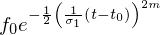

In [2]:
t, t0, nu = symbols("t, t0, nu", real=True)
sigma1, tau1, E, E0, fn, f0 = symbols("sigma1, tau1, E, E0, f_n, f0", positive=True)
m = symbols("m", integer=True, positive=True)

ft = f0*exp(-((t-t0)/sigma1)**(2*m)/2)#/sqrt(2*sigma1*gamma(1+1/m/2))
ft

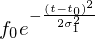

In [3]:
ft.subs(m, 1)

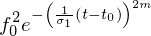

In [4]:
Powt = abs(ft)**2
Powt

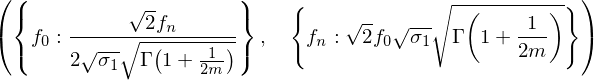

In [5]:
ss_amp = {f0: fn/sqrt(2*sigma1*gamma(1+1/m/2))}
ss_amp_inv = {fn: f0*sqrt(2*sigma1*gamma(1+1/m/2))}
ss_amp, ss_amp_inv

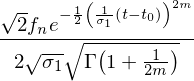

In [6]:
ft = ft.subs(ss_amp)
ft

In [7]:
simplify(integrate(abs(ft)**2, (t, -oo, oo)))

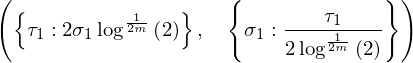

In [8]:
eq = Powt.subs(t, t0)/2 - Powt
hwhm = solve(eq, t)[0]-t0
fwhm = 2*hwhm
ss_fwhm = {tau1: fwhm}
ss_fwhm_inv = {sigma1: sigma1*tau1/fwhm}
ss_fwhm, ss_fwhm_inv

We need to choose $\sigma_1$ such that for all $m=1, \infty$, the bandwidth is the same. We find what is the limit of $E(t)$ is when $m=\infty$

In [9]:
Equality(tau1, ss_fwhm[tau1].limit(m, oo))

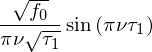

In [10]:
Eoonu = sqrt(f0)*sin(pi*nu*tau1)/(nu*pi)/sqrt(tau1)
Eoonu

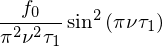

In [11]:
Powoonu = abs(Eoonu)**2
Powoonu

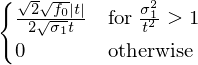

In [12]:
Etoo = inverse_fourier_transform(Eoonu, nu, t).subs(tau1, 2*sigma1)
Etoo

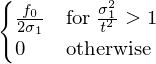

In [13]:
Powoot = abs(Etoo)**2
Powoot

In [14]:
integrate(Powoot.args[0][0], (t, -sigma1, sigma1))

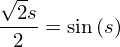

In [15]:
s = symbols("s", positive=True)
eq = Equality(Powoonu.limit(nu, 0)/2, Powoonu)
ff = (pi*nu)**2/f0*tau1
eq = Equality(eq.lhs*ff, eq.rhs*ff)
eq = Equality(sqrt(eq.lhs), sqrt(eq.rhs))

eq = eq.subs(abs(nu)*tau1*pi, s)
eq = eq.subs(nu*tau1*pi, s)
eq = eq.subs(abs(sin(s)), sin(s))

eq

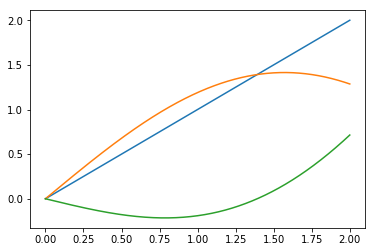

In [16]:
ss = np.linspace(0, 2, 1000)
plt.plot(ss, ss)
plt.plot(ss, np.sqrt(2)*np.sin(ss))
plt.plot(ss, ss-np.sqrt(2)*np.sin(ss))

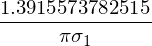

In [17]:
from scipy.optimize import brentq
root_hwhm = brentq(lambda x: x-np.sqrt(2.0)*np.sin(x), 1, 2)
bandwidthoo = 2*root_hwhm/pi/tau1#=pi*nu*tau1
bandwidthoo = bandwidthoo.subs(tau1, 2*sigma1)
bandwidthoo

And the gaussian transforms as

In [18]:
f01t = fourier_transform(ft.subs(m, 1), t, nu)
f01t

In [19]:
Pow01t = abs(f01t)**2
Pow01t

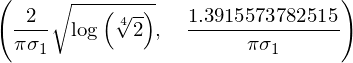

In [20]:
bandwidth01 = solve(Pow01t.subs(nu, 0)/2-Pow01t, nu)
bandwidth01 = bandwidth01[3]-bandwidth01[2]
bandwidth01, bandwidthoo

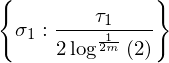

In [21]:
ss_fwhm_inv

In [22]:
Powt.subs(ss_fwhm_inv).subs(t, t0)/Powt.subs(ss_fwhm_inv).subs(t, t0+tau1/2)

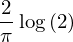

In [23]:
tbp01 = simplify(bandwidth01.subs(ss_fwhm_inv).subs(m, 1)*tau1)
tbp01

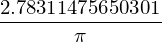

In [24]:
tbpoo = simplify(bandwidthoo.subs(ss_fwhm_inv).limit(m, oo)*tau1)
tbpoo

In [25]:
def ffftfreq(t):
    r"""Calculate the angular frequency axis for a given time axis."""
    dt = t[1]-t[0]
    nu = np.fft.fftshift(np.fft.fftfreq(t.size, dt))
    return nu


def ffftfft(f, t):
    r"""Calculate the Fourier transform."""
    dt = t[1]-t[0]
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(f)))*dt


def iffftfft(f, nu):
    r"""Calculate the inverse Fourier transform."""
    Deltanu = nu[-1]-nu[0]
    return np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(f)))*Deltanu

from scipy.interpolate import interp1d

def estimate_time_bandwith_product(t, m=1):
    f = np.exp(-t**(2*m))
    f2max = np.interp(0, ts, np.abs(f)**2)
    eqf = np.abs(f)**2-f2max/2
    eqff = interp1d(t, eqf)
    tau = brentq(eqff, 0, 1)*2
    
    #print tau
    nu = ffftfreq(t)
    fhat = ffftfft(f, t)
    f2hatmax = np.interp(0, nu, np.abs(fhat)**2)
    eqfhat = np.abs(fhat)**2-f2hatmax/2
    eqfhatf = interp1d(nu, eqfhat)
    B = brentq(eqfhatf, 0, 1)*2
    #print B
    #print tau*B, 2*np.log(2)/np.pi
    
    #plt.subplot(211)
    #plt.plot(t, np.abs(f)**2)
    #plt.xlim(-5, 5)
    #plt.subplot(212)
    #plt.plot(nu, np.abs(fhat)**2)
    #plt.xlim(-2, 2)
    return tau*B

In [26]:
aa = 5
ts = np.linspace(-aa*10, aa*10, aa*10000+1)
mm = np.array(range(1, 101))
tbp = [estimate_time_bandwith_product(ts, i) for i in mm]

/home/oscar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: overflow encountered in power


In [27]:
from scipy.optimize import curve_fit
def model0(m, a, b, B, p):
    return (B-b)*(1-np.exp(-a*(m-1)**p))+b

def model(m, a, p):
    B = 0.885892941378901
    b = 2*np.log(2)/np.pi
    return (B-b)*(1-np.exp(-a*(m-1)**p))+b

def rel_diff(a, b):
    a = abs(a)
    b = abs(b)
    if a > b:
        return 1-b/a
    else:
        return 1-a/b

def time_bandwith_product(m):
    if m == 1:
        return 2*np.log(2)/np.pi
    elif m == oo:
        return 0.885892941378901
    
    #B = 0.885892941378901
    #b = 2*np.log(2)/np.pi
    a, b, B, p = (0.84611760622587673, 0.44076249541699231, 0.87501561821518636, 0.64292796298081856)
    #a, p = (0.8917448398366381, 0.50670832946269484)
    return (B-b)*(1-np.exp(-a*(m-1)**p))+b

[0.84611760622587673, 0.44076249541699231, 0.87501561821518636, 0.64292796298081856]


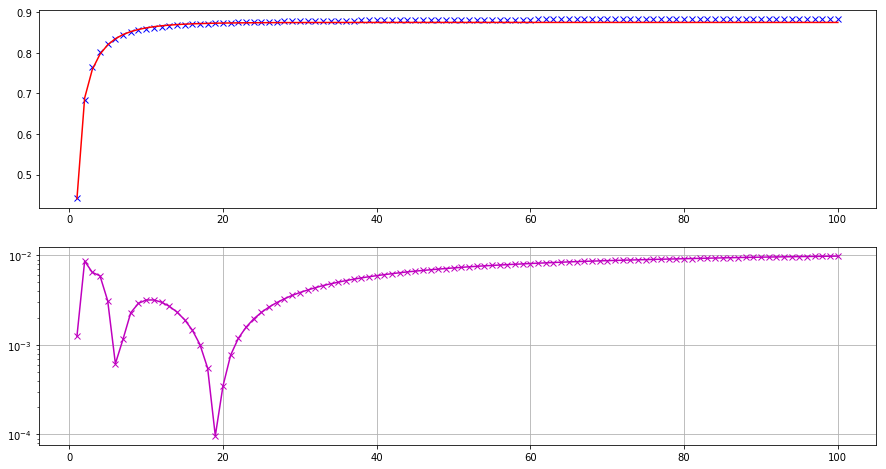

In [28]:
p0 = (1.0, 0.88, 0.4, 0.5)
#p0 = (1.0, 0.6)
fitted = model0(mm, *p0)
aux = 28
fit = curve_fit(model0, mm[:aux], tbp[:aux], p0)[0]
fitted = model0(mm, *fit)
print list(fit)

#time_bandwith_product = interp1d(mm, tbp)

#fitted = [time_bandwith_product(i) for i in mm]

plt.figure(figsize=(15, 8))
plt.subplot(211)
plt.plot(mm, tbp, "bx")
plt.plot(mm, fitted, "r-")

plt.subplot(212)
err = [rel_diff(tbp[i], fitted[i]) for i in range(len(tbp))]
plt.semilogy(mm, err, "mx-")
plt.grid(True)

In [29]:
def square_normalized(t, t0, tau, norm=1):
    f = np.where((t-t0)/tau >=-0.5, 1.0, 0.0)*np.where((t-t0)/tau <=0.5, 1.0, 0.0)
    f = np.sqrt(norm)*f
    return f


def Omega_generalized(t, t0, bandwidth, E, m=1):
    tbp = time_bandwith_product(m)
    tau = tbp/bandwidth
    if m == oo:
        sig = tau/2
        #f = np.sqrt(E)*square(t-t0, 2*sig)/2/sig
        f = np.sqrt(E)*square_normalized(t, t0, tau, E)
    else:
        sigma = tau/(2*np.log(2.0)*(1.0/(2*m)))
        sigma = tau*np.log(2)**(-1.0/(2*m))/2.0
        # print tbp, tau, sigma
        f = np.sqrt(E/(2*sigma*gamma_function(1+1.0/2/m)))
        f = f*np.exp(-0.5*(((t-t0)/sigma)**(2*m)))
    f = np.sqrt(E)*f/np.sqrt(num_integral(t, np.abs(f)**2))
    return f
    

/home/oscar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in power


3.0 3.0
3.0 3.0
3.0 3.0
3.0 2.99999959182


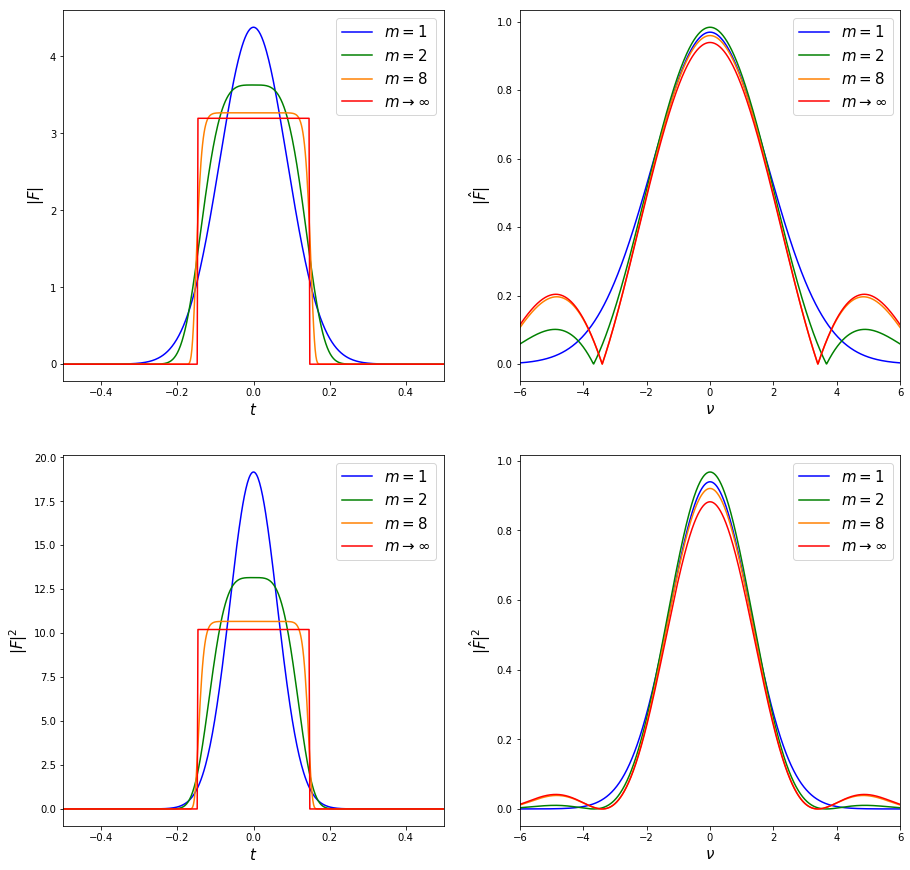

In [30]:
t0s = 0.0
bandwidths = 3.0
Es = 3.0
f01 = Omega_generalized(ts, t0s, bandwidths, Es, 1)
f02 = Omega_generalized(ts, t0s, bandwidths, Es, 2)
f03 = Omega_generalized(ts, t0s, bandwidths, Es, 8)
f99 = Omega_generalized(ts, t0s, bandwidths, Es, 99)
foo = Omega_generalized(ts, t0s, bandwidths, Es, oo)
f = [f01, f02, f03, foo]
#f = [f01, f02, foo]
colours = ["b", "g", (1, 0.5, 0), "r"]
mlabels = ["=1", "=2", "=8", r"\rightarrow\infty"]

nus = ffftfreq(ts)
fhat = [ffftfft(f[i], ts) for i in range(len(f))]

for i in range(len(f)):
    print num_integral(ts, np.abs(f[i])**2), num_integral(nus, np.abs(fhat[i])**2)

plt.figure(figsize=(15, 15))
plt.subplot(221)
for i in range(len(f)):
    plt.plot(ts, np.abs(f[i]), "-", color=colours[i], label=r"$m"+mlabels[i]+"$")
plt.xlim(-0.5, 0.5)
plt.legend(fontsize=15)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$|F|$", fontsize=15)

plt.subplot(222)
for i in range(len(f)):
    plt.plot(nus, np.abs(fhat[i]), "-", color=colours[i], label=r"$m"+mlabels[i]+"$")
plt.xlim(-2*bandwidths, 2*bandwidths)
plt.legend(fontsize=15)
plt.xlabel(r"$\nu$", fontsize=15)
plt.ylabel(r"$|\hat{F}|$", fontsize=15)

plt.subplot(223)
for i in range(len(f)):
    plt.plot(ts, np.abs(f[i])**2, "-", color=colours[i], label=r"$m"+mlabels[i]+"$")
plt.xlim(-0.5, 0.5)
plt.legend(fontsize=15)
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"$|F|^2$", fontsize=15)

plt.subplot(224)
for i in range(len(f)):
    plt.plot(nus, np.abs(fhat[i])**2, "-", color=colours[i], label=r"$m"+mlabels[i]+"$")
plt.xlim(-2*bandwidths, 2*bandwidths)
plt.legend(fontsize=15)
plt.xlabel(r"$\nu$", fontsize=15)
plt.ylabel(r"$|\hat{F}|^2$", fontsize=15)

# Power of a Gaussian beam

We define a gaussian beam in the following way

In [31]:
x, y, z = symbols("x, y, z", real=True)
R = Matrix([x, y, z])
w, lam, kz = symbols("w, lambda k_z", positive=True)
w, lam, kz, E0

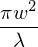

In [32]:
zr=pi*w**2/lam
zr

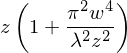

In [33]:
Rz=z*(1+zr**2/z**2)
Rz

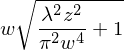

In [34]:
wz=w*sqrt(1+z**2/zr**2)
wz

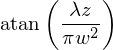

In [35]:
psi=atan(z/zr)
psi

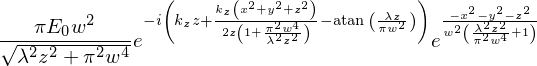

In [36]:
# A Gaussian beam:
R2=R.dot(R)
Electric_field=E0*w/wz
Electric_field=Electric_field.factor()
Electric_field=Electric_field*exp(-R2/wz**2)
Electric_field=Electric_field*exp(-I*(kz*z + kz*R2/2/Rz -psi ))

Electric_field

In [37]:
E, e, r, epsilon0, c, Omega0, hbar = symbols("E e r epsilon_0 c Omega_0 hbar",positive=True)
E, e, r, epsilon0, c, Omega0, hbar

The exact physical meaning of $w$ is important

In [38]:
Iwaist = (Electric_field**2).limit(z, 0)*epsilon0*c/2
Iatw = Iwaist.subs({x: w, y: 0})/Iwaist.subs({x: 0, y: 0})
Iatw

It is the waist at which the intensity drops $e^{-1}$ times the peak intensity.

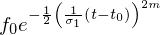

In [39]:
fft = ft.subs(ss_amp_inv)
fft

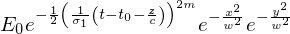

In [40]:
Ewaist=Electric_field.limit(z,0).subs(E0, fft).subs(f0, E0)
Ewaist=Ewaist.subs({t:t-z/c})
Ewaist

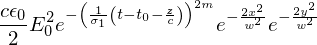

In [41]:
Iwaist = Ewaist**2*epsilon0*c/2
Iwaist

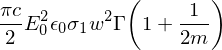

In [42]:
Energy_pulse = integrate(integrate(integrate(Iwaist, (x, -oo, oo)), (y, -oo, oo)), (t, -oo, oo))
Energy_pulse = simplify(Energy_pulse)
Energy_pulse

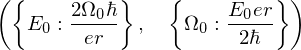

In [43]:
ss_Rabi = {E0: 2*Omega0*hbar/r/e}
ss_Rabi_inv = {Omega0: E0*r*e/hbar/2}
ss_Rabi, ss_Rabi_inv

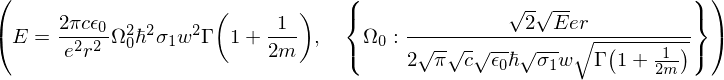

In [44]:
eq = Equality(E, Energy_pulse)
eq = eq.subs(ss_Rabi)
Omega0_sol = solve(eq, Omega0, dict=True)[0]
eq, Omega0_sol

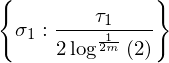

In [54]:
ss_fwhm_inv

In [68]:
print Omega0_sol[Omega0]

sqrt(2)*sqrt(E)*e*r/(2*sqrt(pi)*sqrt(c)*sqrt(epsilon_0)*hbar*sqrt(sigma1)*w*sqrt(gamma(1 + 1/(2*m))))


The time and space dependence of the Rabi frequency then is.

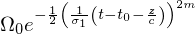

In [46]:
Omegatz = fft.subs(f0, Omega0).subs(t, t-z/c)
Omegatz

Let's check that the field corresponding to this Rabi frequency has the desired energy.

In [51]:
Iact = Electric_field.limit(z, 0).subs(ss_Rabi).subs(Omega0, Omegatz).subs(Omega0_sol)**2*epsilon0*c/2
simplify(integrate(integrate(integrate(Iact, (x, -oo, oo)), (y, -oo, oo)), (t, -oo, oo)))

The default values for bandwiths will be picked so that they correspond to 300 ps.

In [49]:
print tbp01.n()/300e-12*1e-9

1.47090400101768


In [50]:
tbp01.n()

In [72]:
ss_fwhm_inv[sigma1].limit(m, oo)